# DMI Ocean Observations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

1. Get API key
2. Find station id from this table https://confluence.govcloud.dk/pages/viewpage.action?pageId=30015718
3. Download data

In [2]:
import os
api_key = os.environ["DMI_API_KEY"]
# api_key = "e11..." # Replace with correct API key

In [3]:
from fmskill import ModelResult, PointObservation, Connector

m1 = ModelResult("../tests/testdata/Oresund2D.dfsu", item="Surface elevation")
m1

<DfsModelResultItem> 'Oresund2D'
File: ../tests/testdata/Oresund2D.dfsu
- Item: 0: Surface elevation <Surface Elevation> (meter)

<AxesSubplot:title={'center':'UTM-33'}>

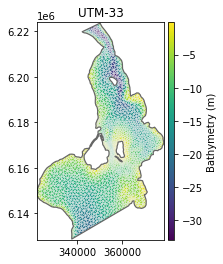

In [8]:
m1.dfs.plot(title=m1.dfs.projection_string)

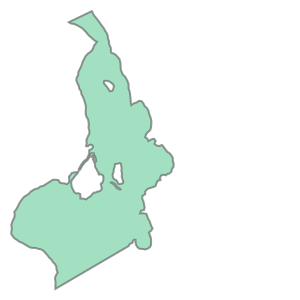

In [26]:
domain = m1.dfs.to_shapely().buffer(0)
domain

In [28]:
import pyproj

from shapely.geometry import Point
from shapely.ops import transform

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32633') # TODO get this from projection_string

project = pyproj.Transformer.from_crs(utm,wgs84, always_xy=True).transform
geo_domain = transform(project, domain)

In [11]:
from fmskill.data.dmi import DMIOceanObsRepository

repo = DMIOceanObsRepository(apikey=api_key)

In [13]:
repo.stations[repo.stations.name.str.startswith('Kø')]

,station_id,lon,lat,name
24,30338,12.5992,55.6894,Københavns Havn
25,30337,12.5992,55.6894,Københavns Havn
43,30478,12.1965,55.4555,Køge Havn I
44,30336,12.5989,55.7043,Københavns Havn
54,30479,12.1965,55.4555,Køge Havn II
57,30339,12.5993,55.6896,Københavns Havn
67,30337,12.5992,55.6894,Københavns Havn
93,30338,12.5992,55.6894,Københavns Havn
99,30339,12.5993,55.6896,Københavns Havn
124,30336,12.5990,55.7044,Københavns Havn


In [55]:
import folium

map_osm = folium.Map(location=[55.5, 12.5], zoom_start=9)
repo.stations.apply(lambda row:folium.Marker(location=[row["lat"], 
                                                  row["lon"]], popup=row["name"]).add_to(map_osm),
     axis=1)
folium.GeoJson(geo_domain, style_function = lambda x:{'fillColor': 'red', 'color': 'black'} ).add_to(map_osm)
map_osm

In [14]:

station_id = "30336" # Kbh havn

df = repo.get_observations(station_id=station_id, start_time=m1.start_time, end_time=m1.end_time, limit=10000)
df.head()

,sealev_dvr
time,
2018-03-04 00:00:00,-0.22
2018-03-04 00:10:00,-0.23
2018-03-04 00:20:00,-0.26
2018-03-04 00:30:00,-0.27
2018-03-04 00:40:00,-0.28


In [15]:
df = df.rename(columns={'sealev_dvr': 'copenhagen_harbour'})
df.head()

,copenhagen_harbour
time,
2018-03-04 00:00:00,-0.22
2018-03-04 00:10:00,-0.23
2018-03-04 00:20:00,-0.26
2018-03-04 00:30:00,-0.27
2018-03-04 00:40:00,-0.28


In [16]:
o1 = PointObservation(df, x=350000, y=6174000) # TODO get UTM coordinates

In [17]:
o1

PointObservation: copenhagen_harbour, x=350000, y=6174000

In [18]:
con  = Connector(o1,m1)
con

<Connector> with 
 -<PointConnector> obs=copenhagen_harbour(n=1001) :: model=Oresund2D

In [19]:
c = con.extract()
c

100%|██████████| 51/51 [00:00<00:00, 7231.56it/s]


<ComparerCollection>
PointComparer: copenhagen_harbour

<AxesSubplot:title={'center':'copenhagen_harbour'}, ylabel='Undefined'>

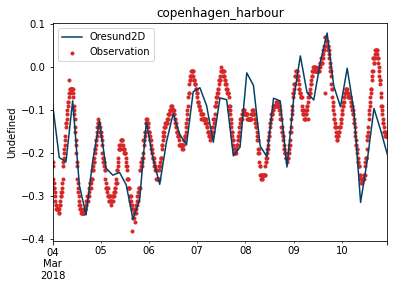

In [27]:
c[0].remove_bias()
c[0].plot_timeseries()

In [28]:
c.skill()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
copenhagen_harbour,1001,2.262592e-17,0.053427,0.053427,0.04095,0.83732,0.304616,0.686999
